In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from statsmodels.api import OLS 
import datetime
import yfinance as yf


In [88]:
df = pd.read_csv(r"C:\Users\Jordi\Desktop\ALGO\algo\aggregated_2022_4000_ticks.csv")

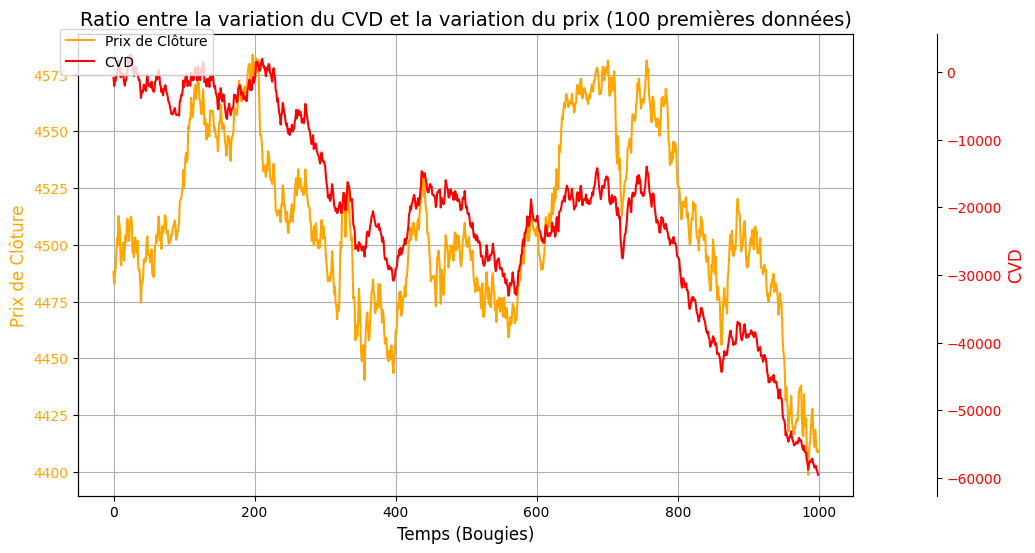

In [89]:
import matplotlib.pyplot as plt

# Sélectionner les 100 premières lignes
df_subset = df.head(1000)

# Création de la figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer les prix de clôture (close) sur le premier axe des ordonnées
ax1.plot(df_subset.index, df_subset['close'], label='Prix de Clôture', color='orange', linewidth=1.5)
ax1.set_xlabel('Temps (Bougies)', fontsize=12)
ax1.set_ylabel('Prix de Clôture', fontsize=12, color='orange')
ax1.tick_params(axis='y', labelcolor='orange')  # Changer la couleur des ticks de l'axe des Y

# Créer un deuxième axe des ordonnées pour le ratio
# ax2 = ax1.twinx()
# ax2.plot(df_subset.index, df_subset['ratio'], label='CVD / Prix Ratio', color='blue', linewidth=2)
# ax2.set_ylabel('Ratio CVD / Prix', fontsize=12, color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')  # Changer la couleur des ticks de l'axe des Y

# Créer un troisième axe des ordonnées pour le CVD
ax3 = ax1.twinx()
# Décaler l'axe à droite pour éviter qu'il se superpose avec ax2
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df_subset.index, df_subset['CVD'], label='CVD', color='red', linewidth=1.5)
ax3.set_ylabel('CVD', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')  # Changer la couleur des ticks de l'axe des Y

# Ajouter une ligne horizontale rouge à y=0 pour visualiser les divergences
# ax2.axhline(0, color='red', linestyle='--', linewidth=1)

# Ajouter le titre et la grille
plt.title('Ratio entre la variation du CVD et la variation du prix (100 premières données)', fontsize=14)
ax1.grid(True)

# Ajouter la légende pour chaque axe
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Afficher le graphique
plt.show()


In [100]:


df['newHighCVD'] = 0
df['newHighPrice'] = 0
for i in range(10, len(df)):
    if df['CVD'][i] == df['CVD'][i-10:i+1].max():
        df.loc[i, 'newHighCVD'] = 1
    if df['close'][i] == df['close'][i-10:i+1].max():
        df.loc[i, 'newHighPrice'] = 1
    
df['HighRatio'] = 0

for i in range(10, len(df)):
    count_newHighCVD = df['newHighCVD'][i-10:i+1].sum()
    
    count_newHighPrice = df['newHighPrice'][i-10:i+1].sum()
    
    if count_newHighPrice != 0:
        df.loc[i, 'HighRatio'] = count_newHighCVD / count_newHighPrice
    else:
        if count_newHighCVD == 0:
            df.loc[i, 'HighRatio'] = 1
        else:
            df.loc[i, 'HighRatio'] = count_newHighCVD / 1



C:\Users\Jordi\AppData\Local\Temp\ipykernel_1472\3598606537.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'HighRatio'] = count_newHighCVD / count_newHighPrice


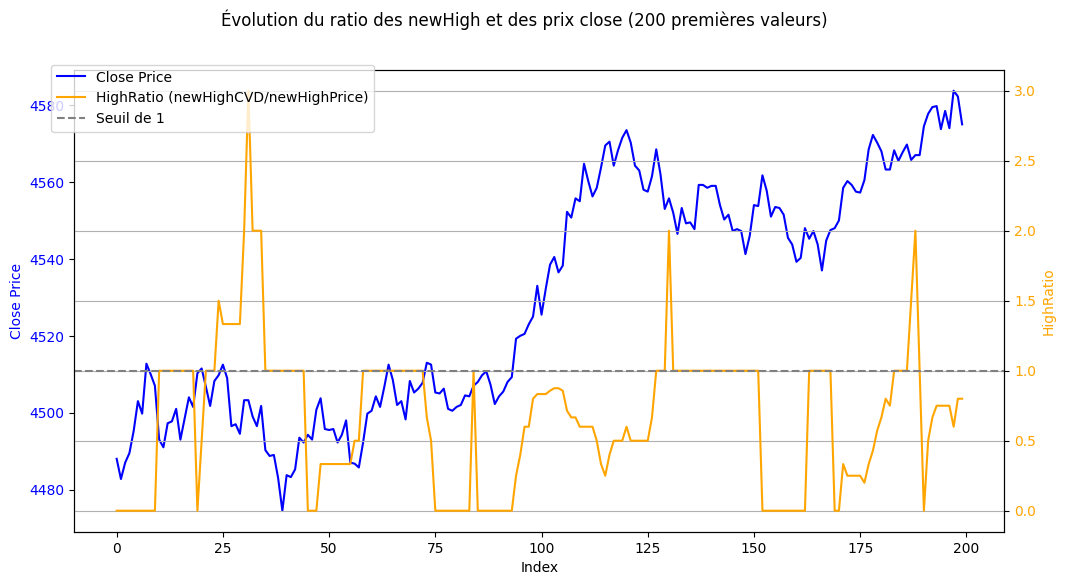

In [101]:
# Limitation du DataFrame aux 200 premières valeurs pour le tracé
df_limited = df.head(200)

# Création de la figure et de l'axe principal
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracé des prix 'close' sur l'axe principal
ax1.plot(df_limited.index, df_limited['close'], label='Close Price', color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Création d'un second axe pour le ratio 'HighRatio'
ax2 = ax1.twinx()
ax2.plot(df_limited.index, df_limited['HighRatio'], label='HighRatio (newHighCVD/newHighPrice)', color='orange')
ax2.axhline(y=1, color='gray', linestyle='--', label='Seuil de 1')
ax2.set_ylabel('HighRatio', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Ajout de la légende et du titre
fig.suptitle("Évolution du ratio des newHigh et des prix close (200 premières valeurs)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid()
plt.show()


In [97]:
print(df.iloc[150])

open                4546.0
high               4554.75
low                 4545.5
close               4554.0
volume               12370
delta                 2250
CVD                  -3163
Date            2022-02-02
Time              15:37:28
newHighCVD               0
newHighPrice             0
HighRatio              NaN
Name: 150, dtype: object


In [102]:
df['cum_volume_price'] = (df['close'] * df['volume']).cumsum()  # Somme cumulative des produits prix*volume
df['cum_volume'] = df['volume'].cumsum()                        # Somme cumulative des volumes
df['VWAP'] = df['cum_volume_price'] / df['cum_volume']          # VWAP

# Suppression des colonnes intermédiaires
df = df.drop(columns=['cum_volume_price', 'cum_volume'])

C:\Users\Jordi\AppData\Local\Temp\ipykernel_1472\3674784563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limited.rename(columns={'Close': 'close'}, inplace=True)


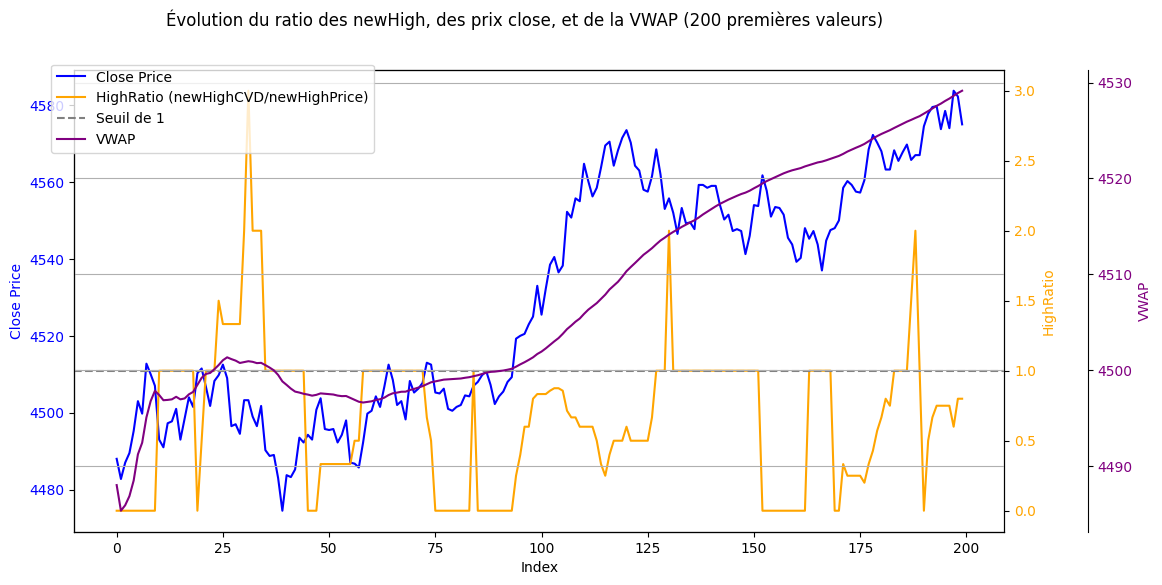

In [116]:
df_limited = df.head(200)
df_limited.rename(columns={'Close': 'close'}, inplace=True)
# Création de la figure et de l'axe principal
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracé des prix 'close' sur l'axe principal
ax1.plot(df_limited.index, df_limited['close'], label='Close Price', color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Création d'un second axe pour le ratio 'HighRatio'
ax2 = ax1.twinx()
ax2.plot(df_limited.index, df_limited['HighRatio'], label='HighRatio (newHighCVD/newHighPrice)', color='orange')
ax2.axhline(y=1, color='gray', linestyle='--', label='Seuil de 1')
ax2.set_ylabel('HighRatio', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Création d'un troisième axe pour la VWAP
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Décale l'axe VWAP pour éviter la superposition
ax3.plot(df_limited.index, df_limited['VWAP'], label='VWAP', color='purple')
ax3.set_ylabel('VWAP', color='purple')
ax3.tick_params(axis='y', labelcolor='purple')

# Ajout de la légende et du titre
fig.suptitle("Évolution du ratio des newHigh, des prix close, et de la VWAP (200 premières valeurs)")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid()
plt.show()